# Titanic

Purpose of the notebook is to 
* explore data
* profile features
* generate new features
* fit a classifier to predict if a given passenger survives or not


## Import Libraries

In [69]:
%matplotlib inline

import os 
import sys

import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder

## Define Constants

In [2]:
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('load_data.ipynb'))
PROJECT_ROOT = os.path.join(NOTEBOOK_DIR, '..')
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
SRC_DIR = os.path.join(PROJECT_ROOT, 'src')

TRAIN_CSV = 'train.csv'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, TRAIN_CSV)

In [3]:
sys.path.append(SRC_DIR)
import preprocess
sys.path.remove(SRC_DIR)

## Import Data

In [4]:
data = pd.read_csv(TRAIN_CSV_PATH)

## Profile Data

In [5]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


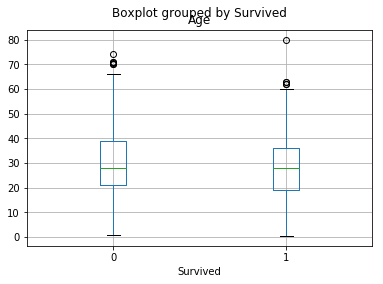

In [7]:
data.boxplot(column='Age', by='Survived')

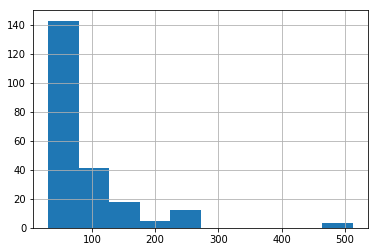

In [8]:
most_expensive = data.Fare > 31
data[most_expensive].Fare.hist()

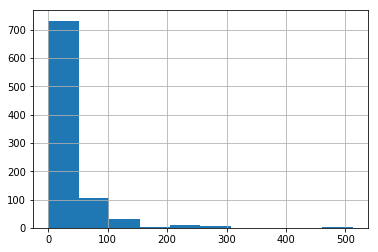

In [9]:
data.Fare.hist()

### Interesting Points

* 62% of passengers died in the training set
* Several ages are missing, this will be an important feature as I can imagine there is a high rate of mortality amongst the younger and elderly
* Nothing is particularly strange about `SibSp` or `Parch` although I am not entirely sure how much these features will be predictive.
* Looking at `Fare` it looks like there may possibly be some outliers/typos since the max value is ~17x the size of the third quartile, seems strange

Further Notes:

Researching the price of a ticket, apparently some of the tickets were incredibly expensive, and it's quite possible the value of a single ticket was 500. Apparently the prices were something like:

* First Class (parlor suite) — £870/$4,350 ($50,000 today).
* First Class (berth)— £30/$150 ($1724 today).
* Second Class — £12/$60 ($690 today).
* Third Class — £3 to £8/$40 ($172 to $460 today).

From: https://www.quora.com/What-were-the-ticket-prices-to-board-the-Titanic


In [10]:
data.loc[:,['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']].describe().T

,count,unique,top,freq
Name,891,891,"Baclini, Miss. Helene Barbara",1
Sex,891,2,male,577
Ticket,891,681,1601,7
Cabin,204,147,G6,4
Embarked,889,3,S,644


### Intersting Points:

#### `Name`
* all unique but seems to often have multiple names inside

#### `Ticket`
* There is a value in every row but some of them up duplicated.
* Mix of numeric, alphabetic, and slashes. Could try splitting these into the alphabetic and numeric part at least

#### `Cabin`
* Many missing values
* Duplicates too
* Some rows appear to contain multiple cabin values
* Could also be split into alphabetic and numeric parts, not sure how to handle multiple/different cabin values

## Cleanup Data

* impute missing `Age`
* do alphabetic, numeric split on `Ticket` and `Cabin`
* parse out titles in `Name`


In [11]:
 from collections import Counter


In [12]:
data['alpha_cabin'] = data.Cabin.apply(lambda cabin: preprocess.parse_alphabetic_characters(cabin))

In [13]:
data['alpha_ticket'] = data.Ticket.apply(lambda ticket: preprocess.parse_alphabetic_characters(ticket))

In [14]:
data['title'] = data.Name.apply(lambda name: preprocess.parse_period_prefixes_to_list(name)[0])

In [ ]:
#Convert columns to categorical

In [35]:
data.alpha_cabin = pd.Categorical(data.alpha_cabin)
data.alpha_ticket = pd.Categorical(data.alpha_ticket)
data.title = pd.Categorical(data.title)

data.Embarked  = pd.Categorical(data.Embarked)
data.Sex = pd.Categorical(data.Sex)

Encode data for model

In [84]:
df = data.loc[:,['Age', 'SibSp', 'Parch', 'Fare']].copy()

columns_to_dummify = ['Pclass', 'alpha_cabin', 'alpha_ticket', 'title', 'Embarked', 'Sex']

In [85]:
pd.get_dummies?

In [86]:
dummies = pd.get_dummies(data.loc[:,columns_to_dummify])

In [87]:
df = df.merge(dummies, left_index=True, right_index=True, validate='one_to_one')

In [88]:
mean_Age = np.mean(df.Age)
df.Age = df.Age.fillna(value=mean_Age)

In [89]:
df.describe()

,Age,SibSp,Parch,Fare,Pclass,alpha_cabin_,alpha_cabin_A,alpha_cabin_B,alpha_cabin_BB,alpha_cabin_BBB,...,title_mr,title_mrs,title_ms,title_rev,title_sir,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208,2.308642,0.771044,0.016835,0.040404,0.007856,0.002245,...,0.580247,0.140292,0.001122,0.006734,0.001122,0.188552,0.086420,0.722783,0.352413,0.647587
std,13.002015,1.102743,0.806057,49.693429,0.836071,0.420397,0.128725,0.197016,0.088337,0.047351,...,0.493796,0.347485,0.033501,0.081830,0.033501,0.391372,0.281141,0.447876,0.477990,0.477990
min,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.699118,0.000000,0.000000,14.454200,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,35.000000,1.000000,0.000000,31.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Generate Model

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier


In [91]:
pipe = Pipeline([
    ('classifier', ExtraTreesClassifier())
])

In [92]:
params = {
    'classifier': [ExtraTreesClassifier(), GradientBoostingClassifier()]
}

In [93]:
gcv = GridSearchCV(pipe, params)

In [95]:
gcv.fit(df, data.Survived)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classifier', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classifier': [ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)]},
       pre_dispatch='2*n_jobs'

In [96]:
gcv.best_score_

0.8092031425364759